# Microscopy Image Processing

#### The purpose of this notebook is to process images obtained by microscopy to extract fluorescence data from them

In [1]:
# Importing the necessary modules

from skimage import io # For importing and saving images
from skimage import exposure # For improving contrast and brightness in an image
from skimage import img_as_float # To transform an 8 bit image to floating points
from skimage.color import * # For color manipulation and transforming
import matplotlib.pyplot as plt # for plotting all the figures
from skimage import filters # for thresholding algorithms
from skimage import morphology # for dilation, erosion and other binary transforms
import numpy as np # for array manipulation
import scipy.ndimage as ndi
from scipy import stats
%matplotlib inline 
# required for viewing images in silico
import skimage.feature as skfeat # for detecting ROIs and OOIs
from math import *
import os

In [2]:
# Search a specific directory to find the images

search_directory = '/Users/Ariel/Desktop/Gemmae_Photos/'
os.chdir(search_directory)
paths = [os.path.join(search_directory, f) for f in os.listdir(search_directory) if '7D' in f]
paths.sort()
all_files = []
all_names = []

for i in range(len(paths)):
    
    os.chdir(paths[i])
    files = filter(os.path.isfile, os.listdir(paths[i]))
    files = [os.path.join(paths[i], f) for f in files]
    files = [file for file in files if '.tif' in file]

    # Sort the image files by their modification time (creation date and time)

    files.sort(key=os.path.getmtime)
    
    all_files.append(files)
    
    names = os.listdir(paths[i])
    names.sort(key=os.path.getmtime)
    names = [name[:-4] for name in names if '.tif' in name]
    
    all_names.append(names)

# Now we have two arrays, all_files and all_names. all_files contains all the paths for the images in a specific list
# which corresponds to the day the images were taken

In [3]:
# We now define all the functions we will use for the analysis

def openImage(file):
    
    img = io.imread(file)
    
    return img

def plotImage(image, index, day, plant):
    
    specific_names = [name for name in all_names[day] if plant in name or plant.upper() in name or plant.lower() in name]
    
    plt.figure(figsize=(5,5), dpi=200)
    plt.title(specific_names[index])
    plt.imshow(image, cmap='gray')

def exporsureAndContrast(image):
    
    clahe_img = exposure.equalize_adapthist(image, clip_limit=0.02)
    
    return clahe_img
    
def image2HSV(image):
    
    img_HSV = rgb2hsv(image)
    
    return img_HSV

def firstSegmentation(image):

    thresh = filters.threshold_otsu(image[:,:,2])
    
    binary = image[:,:,2] < thresh-0.13
    
    return binary

def secondSegmentation(image):
    
    thresh = filters.threshold_otsu(image)
    
    binary = image > thresh
    
    return binary

def objectProcessing(image):
    
    # With this function we will process the image to remove small objects and fill in holes
    # between areas of interest
    
    # Remove small objects
    
    img_wo = morphology.remove_small_objects(image, min_size=20000)
    
    # Binary Closing the gaps
    # For the binary closing we need to define a 2 dimensional array which will determine the
    # pattern for the closing
    
    img_closing = morphology.binary_closing(img_wo, selem=np.ones((15,15)))
    
    img_fill = ndi.binary_fill_holes(img_closing)
    
    img_eroded = morphology.binary_erosion(img_fill, selem=np.ones((5,5)))
    
    return img_eroded

def area_count(binary_img):
    
    count = 0
    
    for row in binary_img:
        
        for pixel in row:
        
            if pixel == False:

                continue

            else:

                count += 1
            
    return (count)

def analyzeCAM1(files, day):
    
    # We declare local scope variables
    
    cam1 = [file for file in files[day] if ('CAM1' or 'Cam1') in file]
    
    global area_values_cam1
    
    area_values_cam1 = []
    
    # cam1 is now a list that contains only CAM1 brightfield images
    
    for i in range(len(cam1)):
        
        print('Analyzing Image', i+1, 'of', len(cam1)) # Check the progress of algorithm
        
        # Read the image
        
        img = openImage(cam1[i])
        
        # Convert to HSV color space for better segmentation
        
        HSV = image2HSV(img)
        
        # Segmentation
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        # Plot images
        
        #plotImage(wo, i, day, cam1) # This is optional (just if one wants to check the segmentation algorithm)
        
        # The approximate pixel size for a 4x objective is 5 micrometers per pixel, so we count the number of white pixels
        # in the image and obtain an approximate count of pixels that contribute to the area, we then multiply that
        # number by 25 to obtain the square micrometers of the plant
        
        area = area_count(wo)
        
        area_values_cam1.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    return area_values_cam1

def analyzeRuby(files, day):
    
    ruby = [file for file in files[day] if 'Ruby' in file or 'Ruby'.upper() in file or 'Ruby'.lower() in file]
    
    global area_values_ruby
    global intensity_values_ruby
    
    area_values_ruby = []
    intensity_values_ruby = []
    
    for i in range(len(ruby)//2):
        
        print('Analyzing Image', i+1, 'of', len(ruby))
        
        img = openImage(ruby[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'Ruby')
        
        area = area_count(wo)
        
        area_values_ruby.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    # This loop corresponds to the fluorescent reporter images
        
    for j in range(len(ruby)//2, len(ruby)):
        
        print('Analyzing Image', j+1, 'of', len(ruby))
        
        img = openImage(ruby[j])
        
        img = img[:,:,0] # We will use only the red channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'Ruby')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_ruby.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return
    
def analyzeHYPET(files, day):
    
    hypet = [file for file in files[day] if 'Hypet' in file or 'Hypet'.upper() in file or 'Hypet'.lower() in file or 'Ypet' in file or 'Ypet'.upper() in file or 'Ypet'.lower() in file or 'HYPETi' in file]
    
    global area_values_hypet
    global intensity_values_hypet
    
    area_values_hypet = []
    intensity_values_hypet = []
    
    for i in range(len(hypet)//2):
        
        print('Analyzing Image', i+1, 'of', len(hypet))
        
        img = openImage(hypet[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'ypet')
        
        area = area_count(wo)
        
        area_values_hypet.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    for j in range(len(hypet)//2, len(hypet)):
        
        print('Analyzing Image', j+1, 'of', len(hypet))
        
        img = openImage(hypet[j])
        
        img = img[:,:,1] # We will use only the green channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'ypet')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_hypet.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return
        
def analyzeVenus(files, day):
    
    venus = [file for file in files[day] if ('Venus' in file and ('N7' not in file and 'LTI' not in file)) or ('Venus'.upper() in file and ('N7' not in file and 'LTI' not in file)) or ('Venus'.lower() in file and ('N7' not in file and 'LTI' not in file))]
    
    global area_values_venus
    global intensity_values_venus
    
    area_values_venus = [] 
    intensity_values_venus = []
    
    for i in range(len(venus)//2):
        
        print('Analyzing Image', i+1, 'of', len(venus))
        
        img = openImage(venus[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'venus')
        
        area = area_count(wo)
        
        area_values_venus.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    for j in range(len(venus)//2, len(venus)):
        
        print('Analyzing Image', j+1, 'of', len(venus))
        
        img = openImage(venus[j])
        
        img = img[:,:,1] # We will use only the green channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'venus')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_venus.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return
    
def analyzeVenusLTI(files, day):

    venuslti = [file for file in files[day] if 'Venuslti' in file or 'Venuslti'.upper() in file or 'Venuslti'.lower() in file]
    
    global area_values_venuslti
    global intensity_values_venuslti
    
    area_values_venuslti = []
    intensity_values_venuslti = []
        
    for i in range(len(venuslti)//2):
        
        print('Analyzing Image', i+1, 'of', len(venuslti))
        
        img = openImage(venuslti[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'venuslti')
        
        area = area_count(wo)
        
        area_values_venuslti.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    for j in range(len(venuslti)//2, len(venuslti)):
        
        print('Analyzing Image', j+1, 'of', len(venuslti))
        
        img = openImage(venuslti[j])
        
        img = img[:,:,1] # We will use only the green channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'venuslti')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_venuslti.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return

def analyzeVenusN7(files, day):
    
    venusn7 = [file for file in files[day] if 'Venusn7' in file or 'Venusn7'.upper() in file or 'Venusn7'.lower() in file]
    
    global area_values_venusn7
    global intensity_values_venusn7
    
    area_values_venusn7 = []
    intensity_values_venusn7 = []

    for i in range(len(venusn7)//2):
        
        print('Analyzing Image', i+1, 'of', len(venusn7))
        
        img = openImage(venusn7[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'venusn7')
        
        area = area_count(wo)
        
        area_values_venusn7.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    for j in range(len(venusn7)//2, len(venusn7)):
        
        print('Analyzing Image', j+1, 'of', len(venusn7))
        
        img = openImage(venusn7[j])
        
        img = img[:,:,1] # We will use only the green channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'venusn7')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_venusn7.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return

def analyzeTurq(files, day):
    
    turq = [file for file in files[day] if ('Turq' in file and 'Lti' not in file and 'Lti'.lower() not in file and 'Lti'.upper() not in file)  or ('Turq'.upper() in file and 'Lti' not in file and 'Lti'.lower() not in file and 'Lti'.upper() not in file) or ('Turq'.lower() in file and 'Lti' not in file and 'Lti'.lower() not in file and 'Lti'.upper() not in file)]
    
    global area_values_turq
    global intensity_values_turq
    
    area_values_turq = []
    intensity_values_turq = []
    
    for i in range(len(turq)//2):
        
        print('Analyzing Image', i+1, 'of', len(turq))
        
        img = openImage(turq[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'Turq')
        
        area = area_count(wo)
        
        area_values_turq.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
    
    for j in range(len(turq)//2, len(turq)):
        
        print('Analyzing Image', j+1, 'of', len(turq))
        
        img = openImage(turq[j])
        
        img = img[:,:,2] # We will use only the blue channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'Turq')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_turq.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return

def analyzeTurqLTI(files, day):
    
    turqlti = [file for file in files[day] if 'TurqLti' in file or 'TurqLti'.upper() in file or 'TurqLti'.lower() in file]
    
    global area_values_turqlti
    global intensity_values_turqlti
    
    area_values_turqlti = []
    intensity_values_turqlti = []
                                                
    for i in range(len(turqlti)//2):
        
        print('Analyzing Image', i+1, 'of', len(turqlti))
        
        img = openImage(turqlti[i])
        
        HSV = image2HSV(img)
        
        segmented = firstSegmentation(HSV)
        
        wo = objectProcessing(segmented)
        
        #plotImage(wo, i, day, 'TurqLti')
        
        area = area_count(wo)
        
        area_values_turqlti.append(area*25)
        
        print('The approximate area for Image', i+1, 'is', area*25, 'square micrometers')
        
    for j in range(len(turqlti)//2, len(turqlti)):
        
        print('Analyzing Image', j+1, 'of', len(turqlti))
        
        img = openImage(turqlti[j])
        
        img = img[:,:,2] # We will use only the blue channel for the fluorescence information 
        
        segmented = secondSegmentation(img)
        
        #wo = objectProcessing(segmented)
        
        #plotImage(segmented, j, day, 'TurqLti')
        
        #area = area_count(wo)
        
        #print('The approximate area for Image', j+1, 'is', area*25, 'square micrometers')
        
        values = segmented*img
        
        intensity = np.sum(values)
        
        intensity_values_turqlti.append(intensity)
        
        print('The intensity of the fluorescent reporter is', intensity)
    
    return

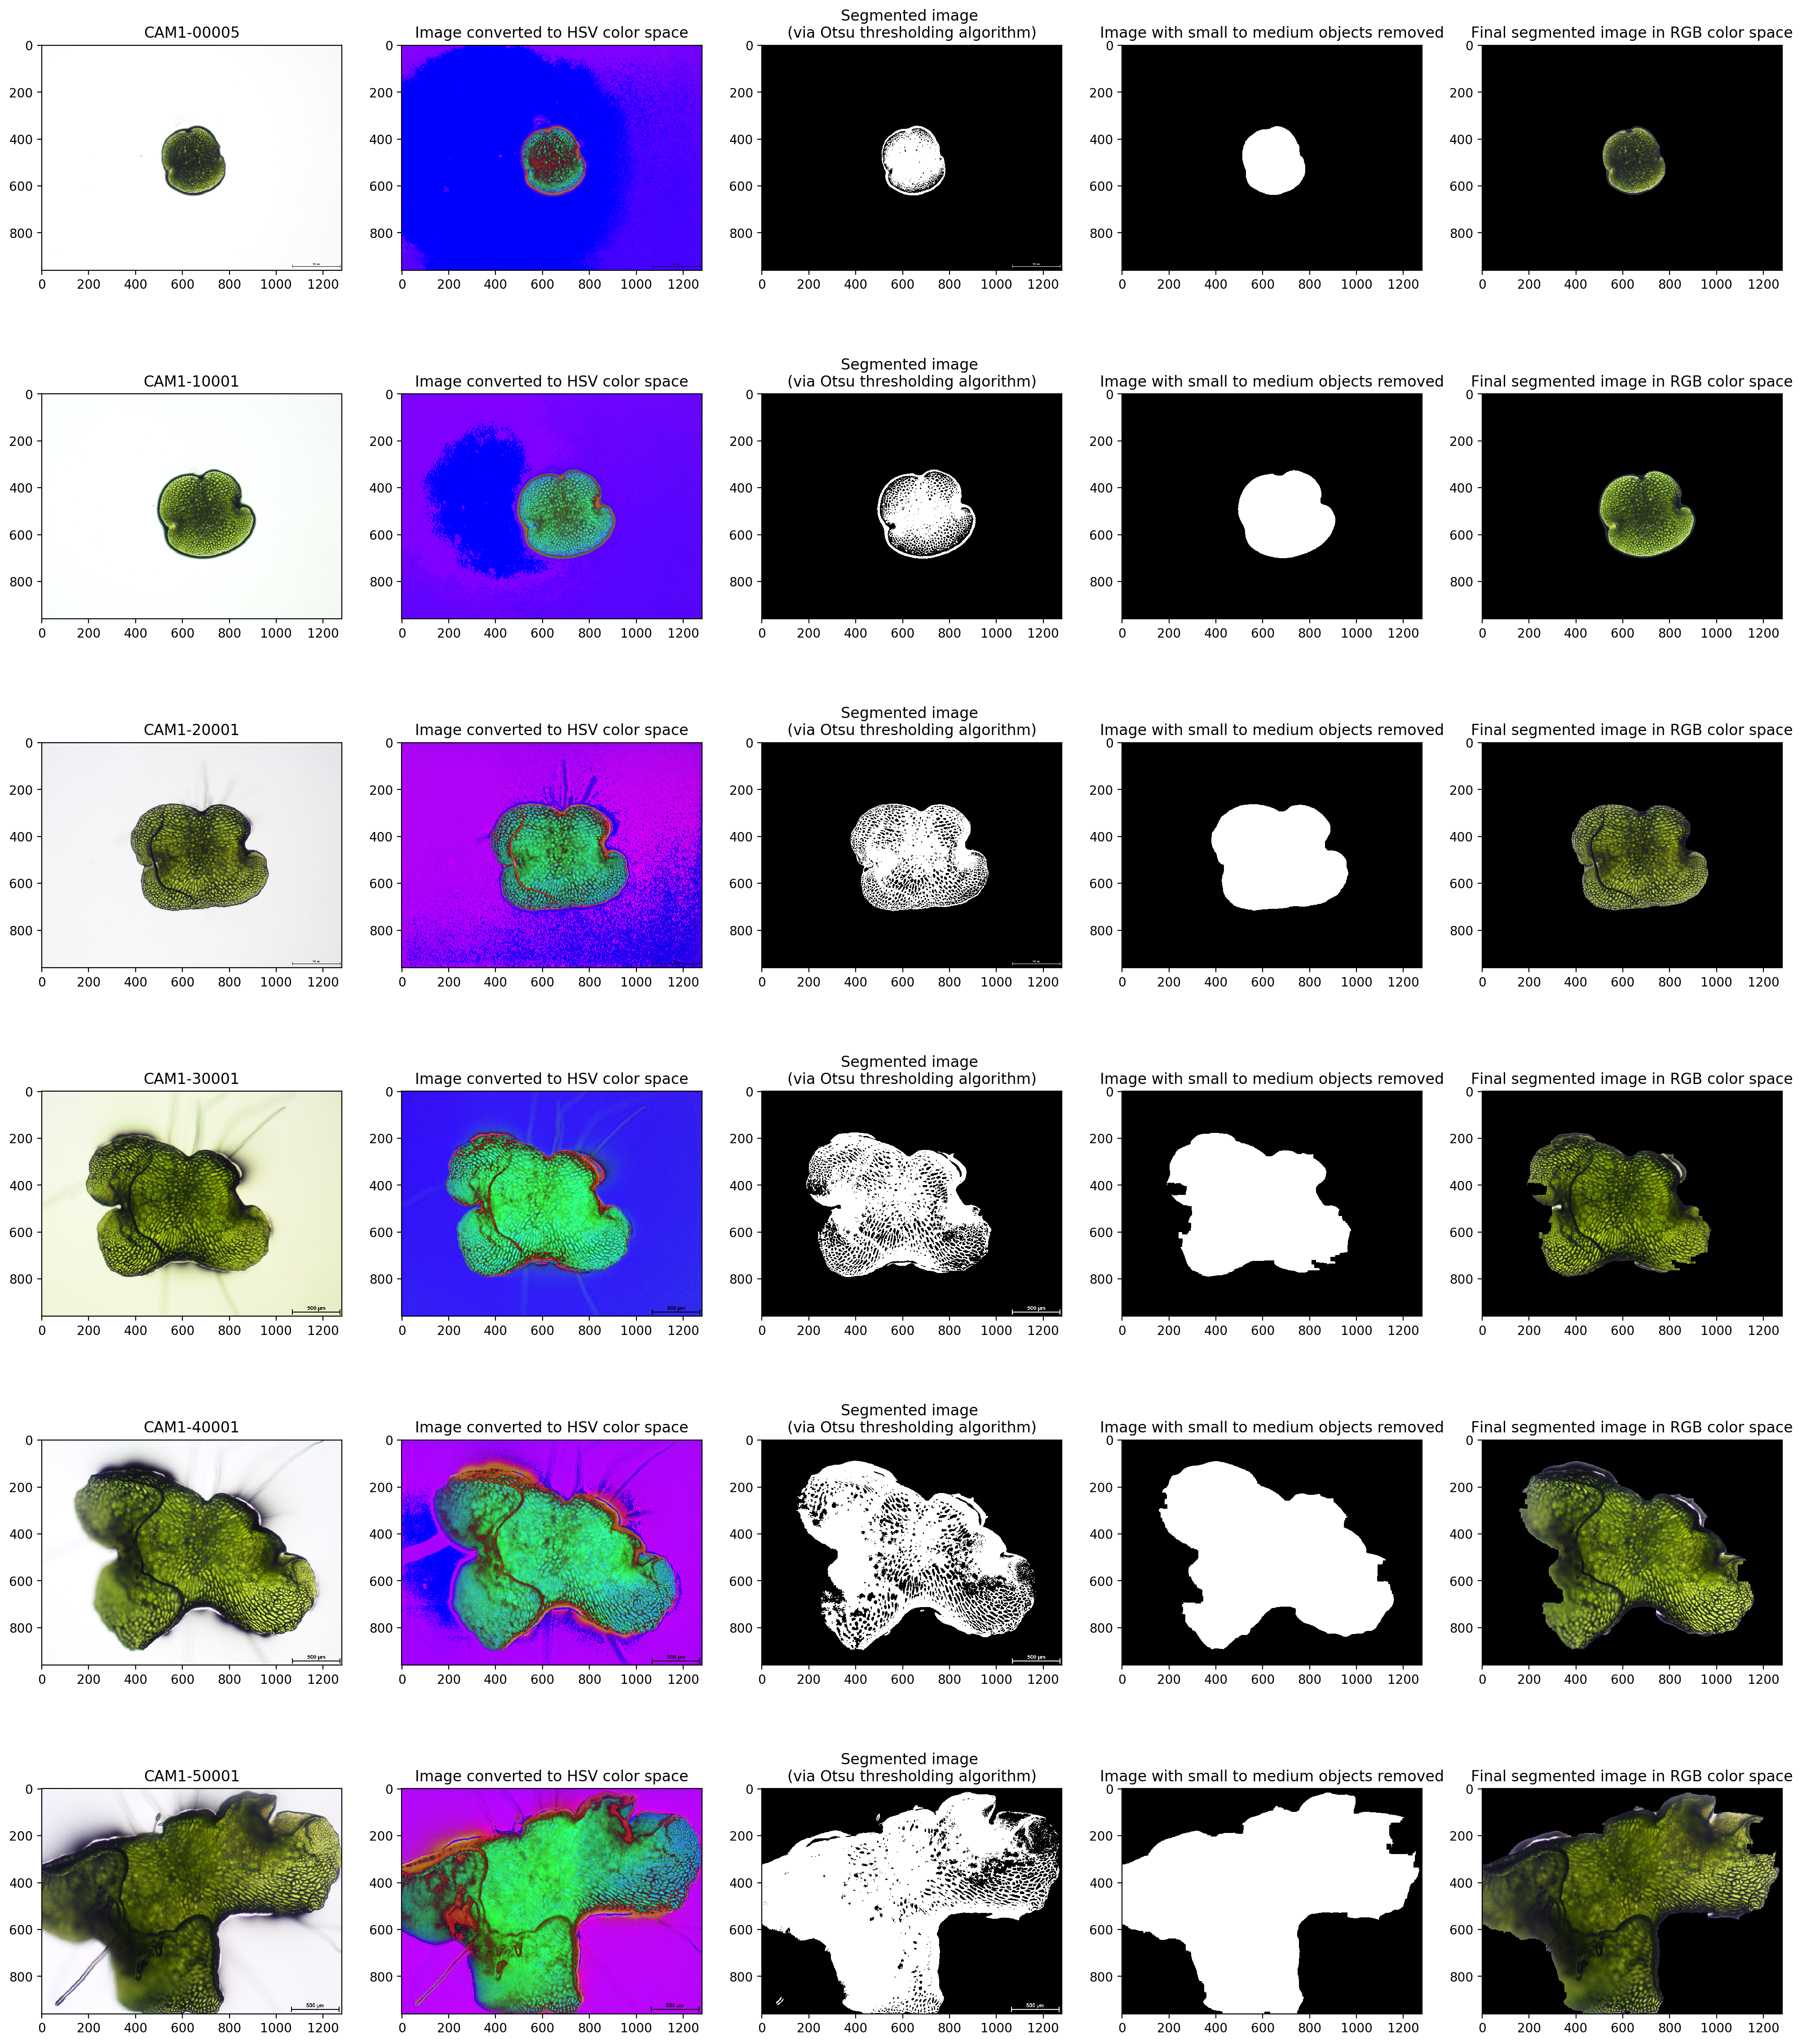

In [7]:
# Figure output for specific plant

img, axis = plt.subplots(nrows = 6, ncols = 5, figsize = (25, 30), dpi=200)

for i in range(0, len(all_files)):
    
    img = io.imread(all_files[i][0])
    
    HSV = image2HSV(img)
        
    # Segmentation
        
    segmented = firstSegmentation(HSV)
        
    wo = objectProcessing(segmented)
    
    r = img[:,:,0]*wo
    g = img[:,:,1]*wo
    b = img[:,:,2]*wo
    
    final = np.dstack((r,g,b))
    
    axis[i][0].imshow(img, cmap='gray')
    axis[i][0].set_title(all_names[i][0])
    axis[i][1].imshow(HSV)
    axis[i][1].set_title('Image converted to HSV color space')
    axis[i][2].imshow(segmented, cmap='gray')
    axis[i][2].set_title('Segmented image \n(via Otsu thresholding algorithm)')
    axis[i][3].imshow(wo, cmap='gray')
    axis[i][3].set_title('Image with small to medium objects removed')
    axis[i][4].imshow(final, cmap='gray')
    axis[i][4].set_title('Final segmented image in RGB color space')
    
plt.savefig('/Users/alejandro/Desktop/MP Intensidad vs Area.png', dpi=300, bbox_inches='tight')

In [99]:
cam1_area = []
ruby_area = []
hypet_area = []
venus_area = []
venuslti_area = []
venusn7_area = []
turq_area = []
turqlti_area = []

ruby_intensity = []
hypet_intensity = []
venus_intensity = []
venuslti_intensity = []
venusn7_intensity = []
turq_intensity = []
turqlti_intensity = []

for day in range(0, 6):
    
    analyzeCAM1(all_files, day)
    analyzeRuby(all_files, day)
    analyzeHYPET(all_files, day)
    analyzeVenus(all_files, day)
    analyzeVenusLTI(all_files, day)
    analyzeVenusN7(all_files, day)
    analyzeTurq(all_files, day)
    analyzeTurqLTI(all_files, day)
    
    # Save the data
    
    cam1_area.append(area_values_cam1)
    ruby_area.append(area_values_ruby)
    hypet_area.append(area_values_hypet)
    venus_area.append(area_values_venus)
    venuslti_area.append(area_values_venuslti)
    venusn7_area.append(area_values_venusn7)
    turq_area.append(area_values_turq)
    turqlti_area.append(area_values_turqlti)

    ruby_intensity.append(intensity_values_ruby)
    hypet_intensity.append(intensity_values_hypet)
    venus_intensity.append(intensity_values_venus)
    venuslti_intensity.append(intensity_values_venuslti)
    venusn7_intensity.append(intensity_values_venusn7)
    turq_intensity.append(intensity_values_turq)
    turqlti_intensity.append(intensity_values_turqlti)

Analyzing Image 1 of 16


/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


The approximate area for Image 1 is 1519675 square micrometers
Analyzing Image 2 of 16
The approximate area for Image 2 is 941500 square micrometers
Analyzing Image 3 of 16
The approximate area for Image 3 is 1543250 square micrometers
Analyzing Image 4 of 16
The approximate area for Image 4 is 1167600 square micrometers
Analyzing Image 5 of 16
The approximate area for Image 5 is 1453825 square micrometers
Analyzing Image 6 of 16
The approximate area for Image 6 is 1434950 square micrometers
Analyzing Image 7 of 16
The approximate area for Image 7 is 1063625 square micrometers
Analyzing Image 8 of 16
The approximate area for Image 8 is 1195100 square micrometers
Analyzing Image 9 of 16
The approximate area for Image 9 is 1240550 square micrometers
Analyzing Image 10 of 16
The approximate area for Image 10 is 1077725 square micrometers
Analyzing Image 11 of 16
The approximate area for Image 11 is 1196950 square micrometers
Analyzing Image 12 of 16
The approximate area for Image 12 is 98

/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:269: RuntimeWarning: divide by zero encountered in true_divide
  out_s = delta / out_v


The approximate area for Image 14 is 18976575 square micrometers
Analyzing Image 15 of 29
The intensity of the fluorescent reporter is 27604965
Analyzing Image 16 of 29
The intensity of the fluorescent reporter is 27084804
Analyzing Image 17 of 29
The intensity of the fluorescent reporter is 31569475
Analyzing Image 18 of 29
The intensity of the fluorescent reporter is 25354029
Analyzing Image 19 of 29
The intensity of the fluorescent reporter is 22738793
Analyzing Image 20 of 29
The intensity of the fluorescent reporter is 19868233
Analyzing Image 21 of 29
The intensity of the fluorescent reporter is 30525602
Analyzing Image 22 of 29
The intensity of the fluorescent reporter is 22892258
Analyzing Image 23 of 29
The intensity of the fluorescent reporter is 26212315
Analyzing Image 24 of 29
The intensity of the fluorescent reporter is 27393175
Analyzing Image 25 of 29
The intensity of the fluorescent reporter is 26038592
Analyzing Image 26 of 29
The intensity of the fluorescent reporter

In [100]:
all_areas = []
all_intensities = []

all_areas.append(cam1_area)
all_areas.append(ruby_area)
all_areas.append(hypet_area)
all_areas.append(venus_area)
all_areas.append(venuslti_area)
all_areas.append(venusn7_area)
all_areas.append(turq_area)
all_areas.append(turqlti_area)

all_intensities.append(ruby_intensity)
all_intensities.append(hypet_intensity)
all_intensities.append(venus_intensity)
all_intensities.append(venuslti_intensity)
all_intensities.append(venusn7_intensity)
all_intensities.append(turq_intensity)
all_intensities.append(turqlti_intensity)

In [101]:
names_brightfield = ['CAM1', 'RUBY', 'HYPET', 'VENUS', 'VENUS LTI', 'VENUS N7', 'TURQ', 'TURQ LTI']
names_intensity = ['RUBY', 'HYPET', 'VENUS', 'VENUS LTI', 'VENUS N7', 'TURQ', 'TURQ LTI']

medias_grafico_area = {}
medias_grafico_intensidad = {}

desv_grafico_area = {}
desv_grafico_intensidad = {}

for i in range(len(all_areas)):
    
    medias_grafico_area[names_brightfield[i]] = []
    desv_grafico_area[names_brightfield[i]] = []
    
    for j in range(len(all_areas[i])):
        
        media = np.mean(all_areas[i][j])
        std = np.std(all_areas[i][j])
        
        medias_grafico_area[names_brightfield[i]].append(media)
        desv_grafico_area[names_brightfield[i]].append(std)
        
for i in range(len(all_intensities)):
    
    medias_grafico_intensidad[names_intensity[i]] = []
    desv_grafico_intensidad[names_intensity[i]] = []
    
    for j in range(len(all_intensities[i])):
        
        media = np.mean(all_intensities[i][j])
        std = np.std(all_intensities[i][j])
        
        medias_grafico_intensidad[names_intensity[i]].append(media)
        desv_grafico_intensidad[names_intensity[i]].append(std)

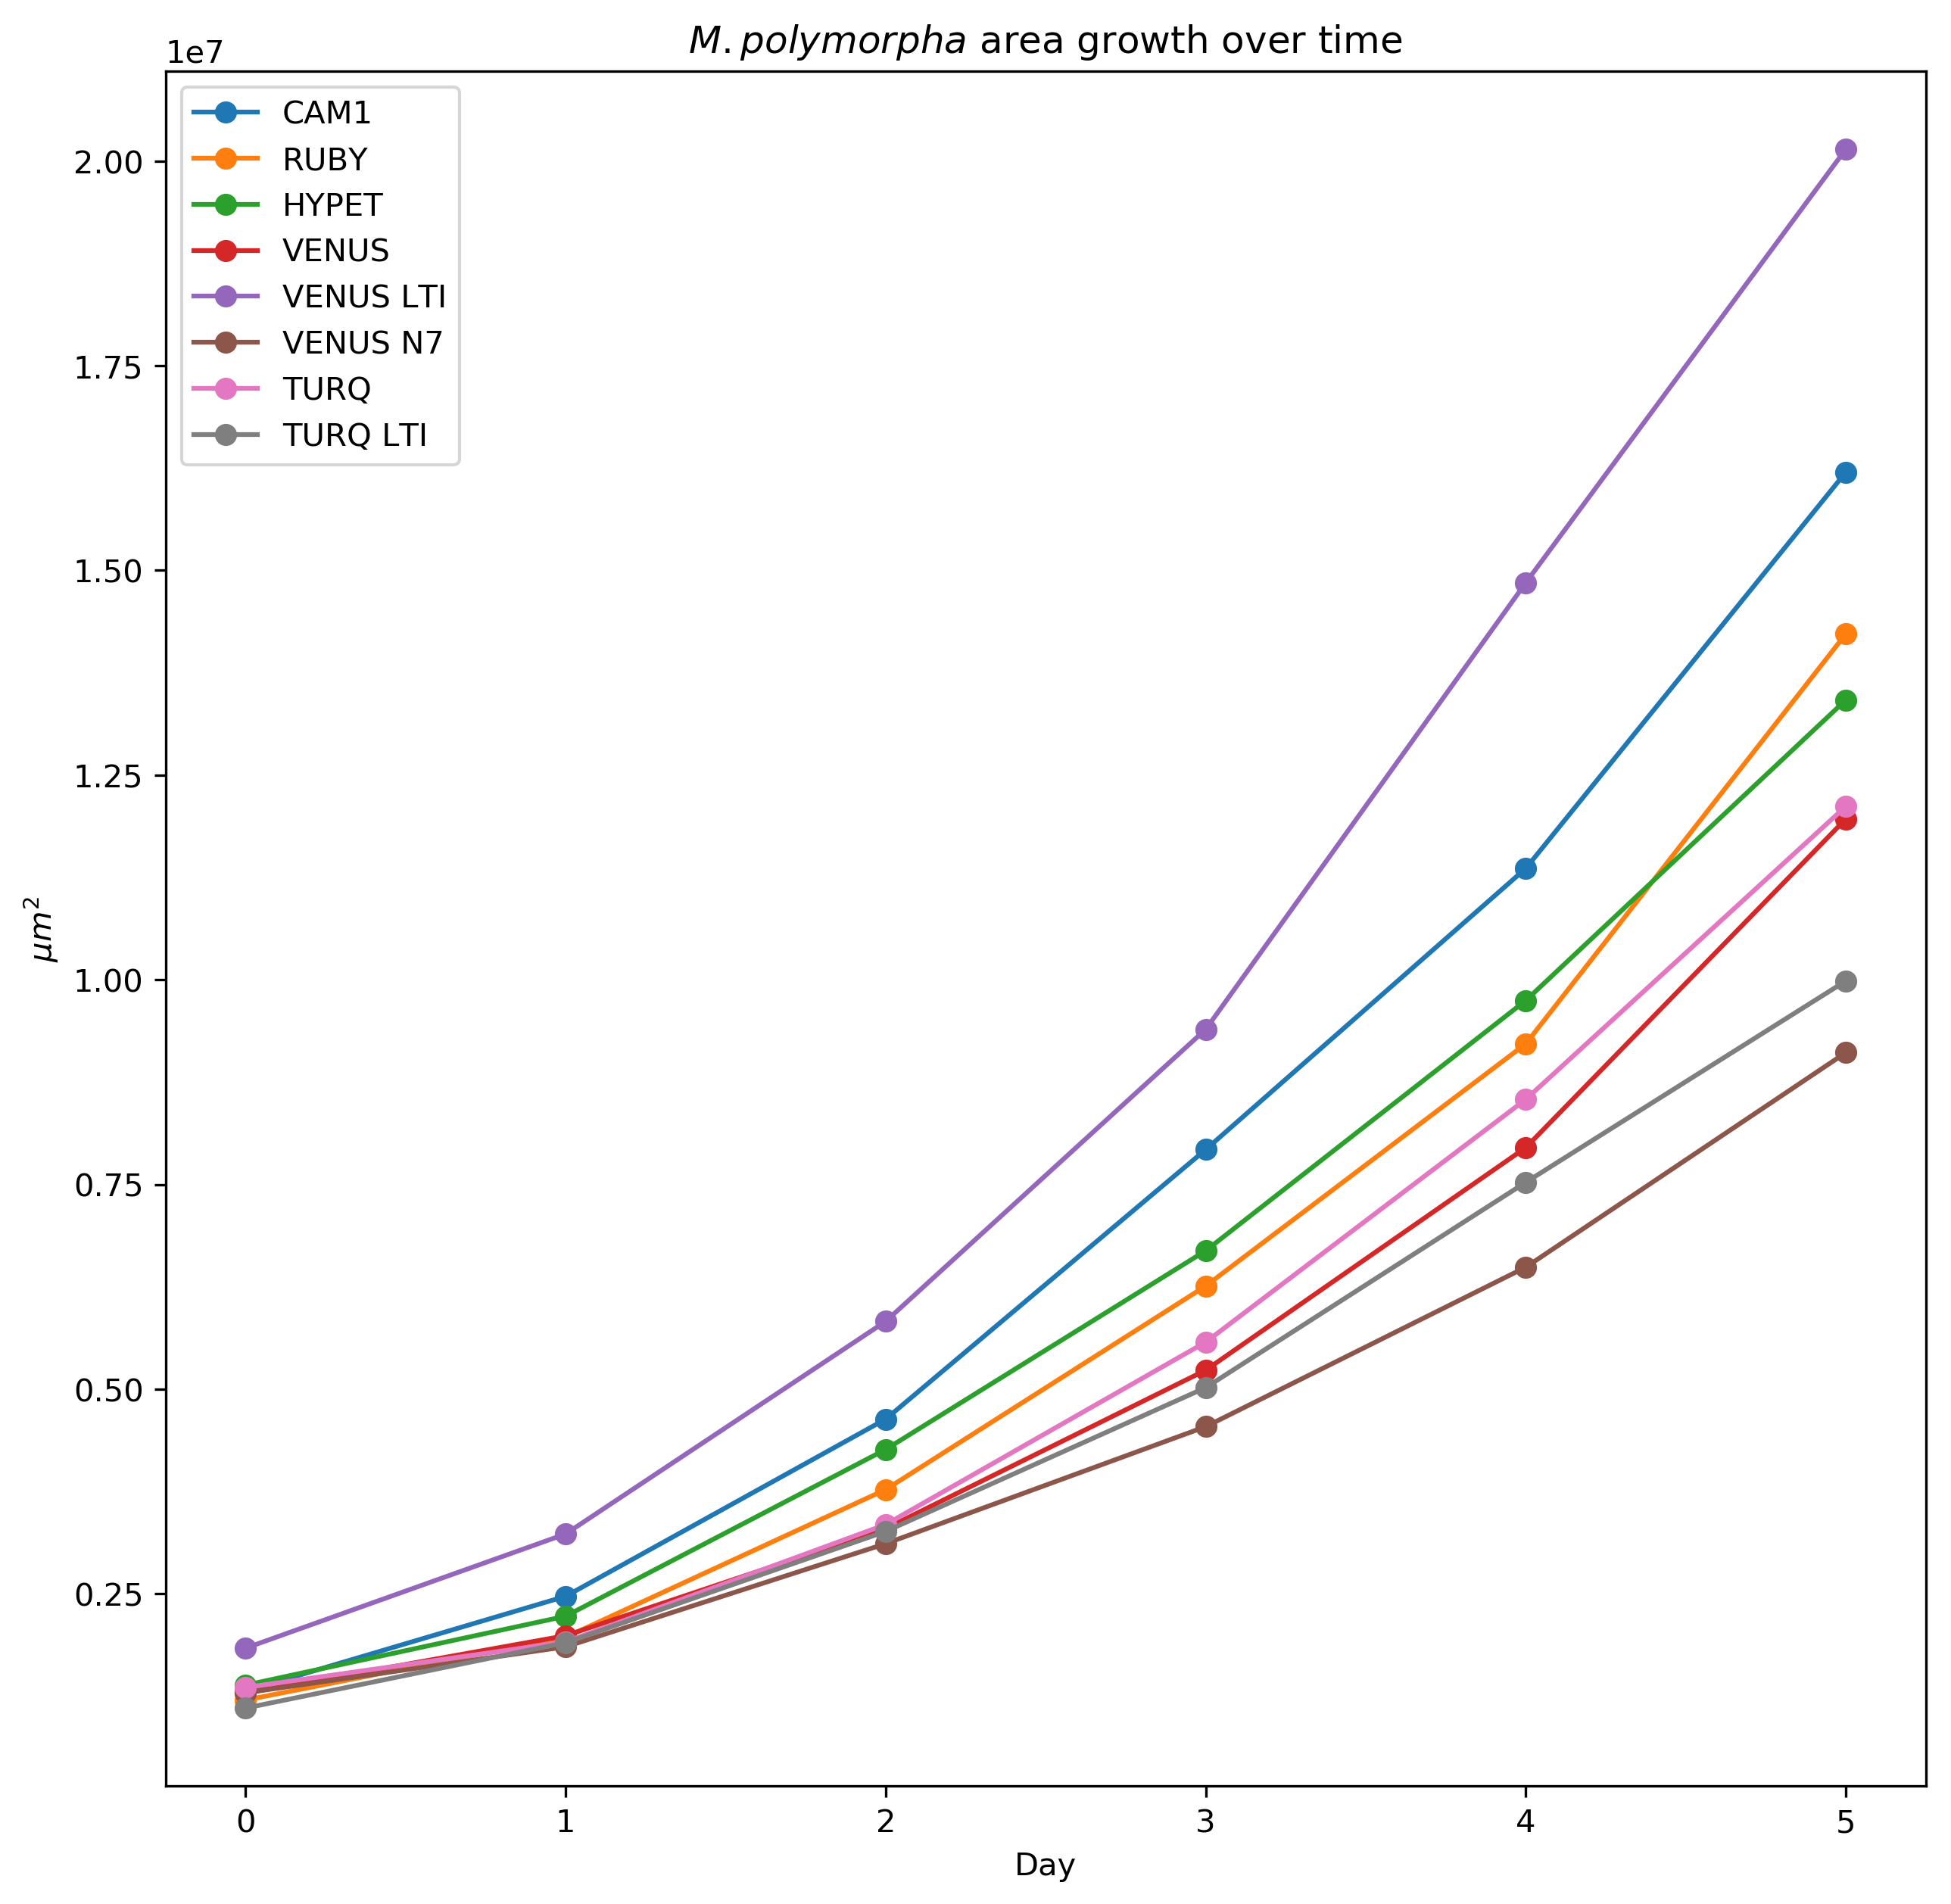

In [158]:
# Plotting the graphs

plt.figure(figsize = (10,10), dpi=300)
plt.title('$\it{M. polymorpha}$'+' area growth over time')
x_axis = [0,1,2,3,4,5]
for name in names_brightfield:
    #plt.errorbar(x_axis, medias_grafico_area[name], yerr = desv_grafico_area[name], fmt='o', linestyle='-')
    plt.plot(x_axis, medias_grafico_area[name], marker='o')
plt.legend(names_brightfield, loc='upper left')
plt.ylabel(r'$\mu m^2$')
plt.xlabel('Day')

plt.savefig('/Users/alejandro/Desktop/MP Area vs Dias.png', dpi=500)

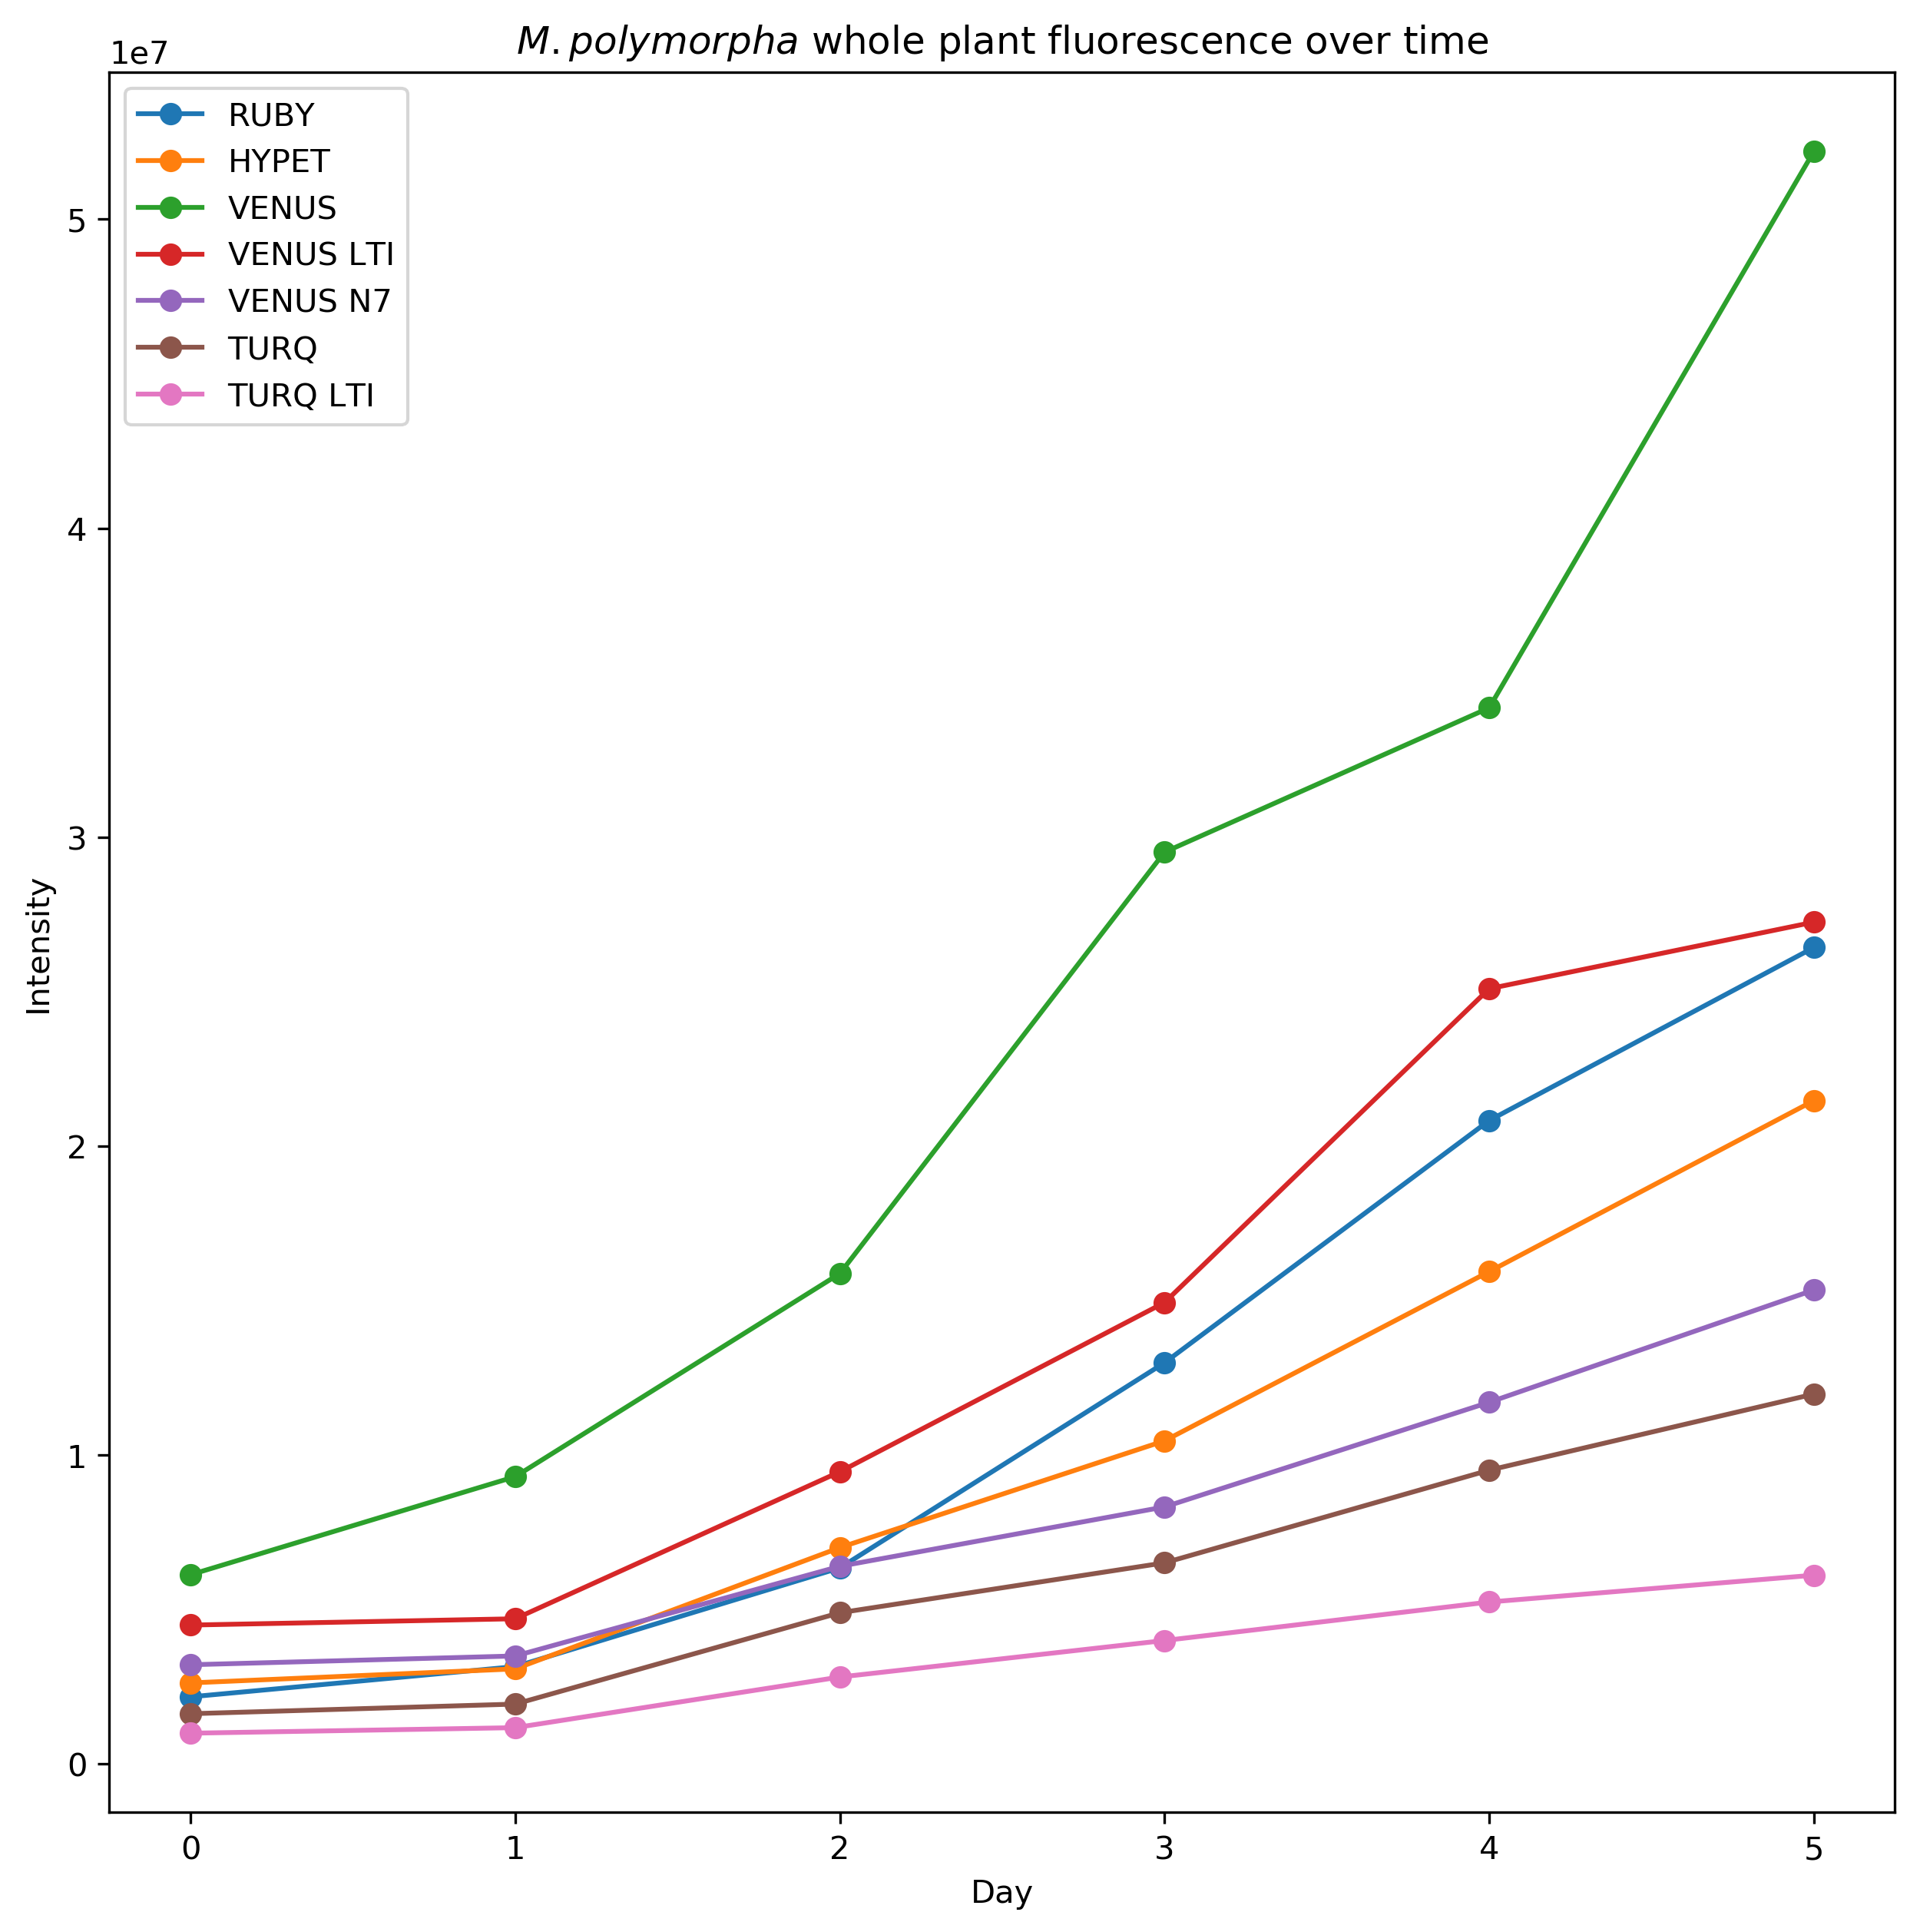

In [159]:
# Plotting the graphs

plt.figure(figsize = (10,10), dpi=300)
plt.title('$\it{M. polymorpha}$'+' whole plant fluorescence over time')
x_axis = [0,1,2,3,4,5]
for name in names_intensity:
    #plt.errorbar(x_axis, medias_grafico_area[name], yerr = desv_grafico_area[name], fmt='o', linestyle='-')
    plt.plot(x_axis, medias_grafico_intensidad[name], marker='o')
plt.legend(names_intensity, loc='upper left')
plt.ylabel('Intensity')
plt.xlabel('Day')

plt.savefig('/Users/alejandro/Desktop/MP Intensidad vs Dias.png', dpi=500)

In [160]:
# Normalizing the Intensity by the Area

normalized = {}
        
for i in range(1, len(names_brightfield)):
    
    name = names_brightfield[i]
    normalized[name] = []
    
    for j in range(0, len(medias_grafico_intensidad[name])):
    
        intensidad = medias_grafico_intensidad[name][j]
        area = medias_grafico_area[name][j]
    
        normalizado = intensidad/area # floating point division
    
        normalized[name].append(normalizado)       

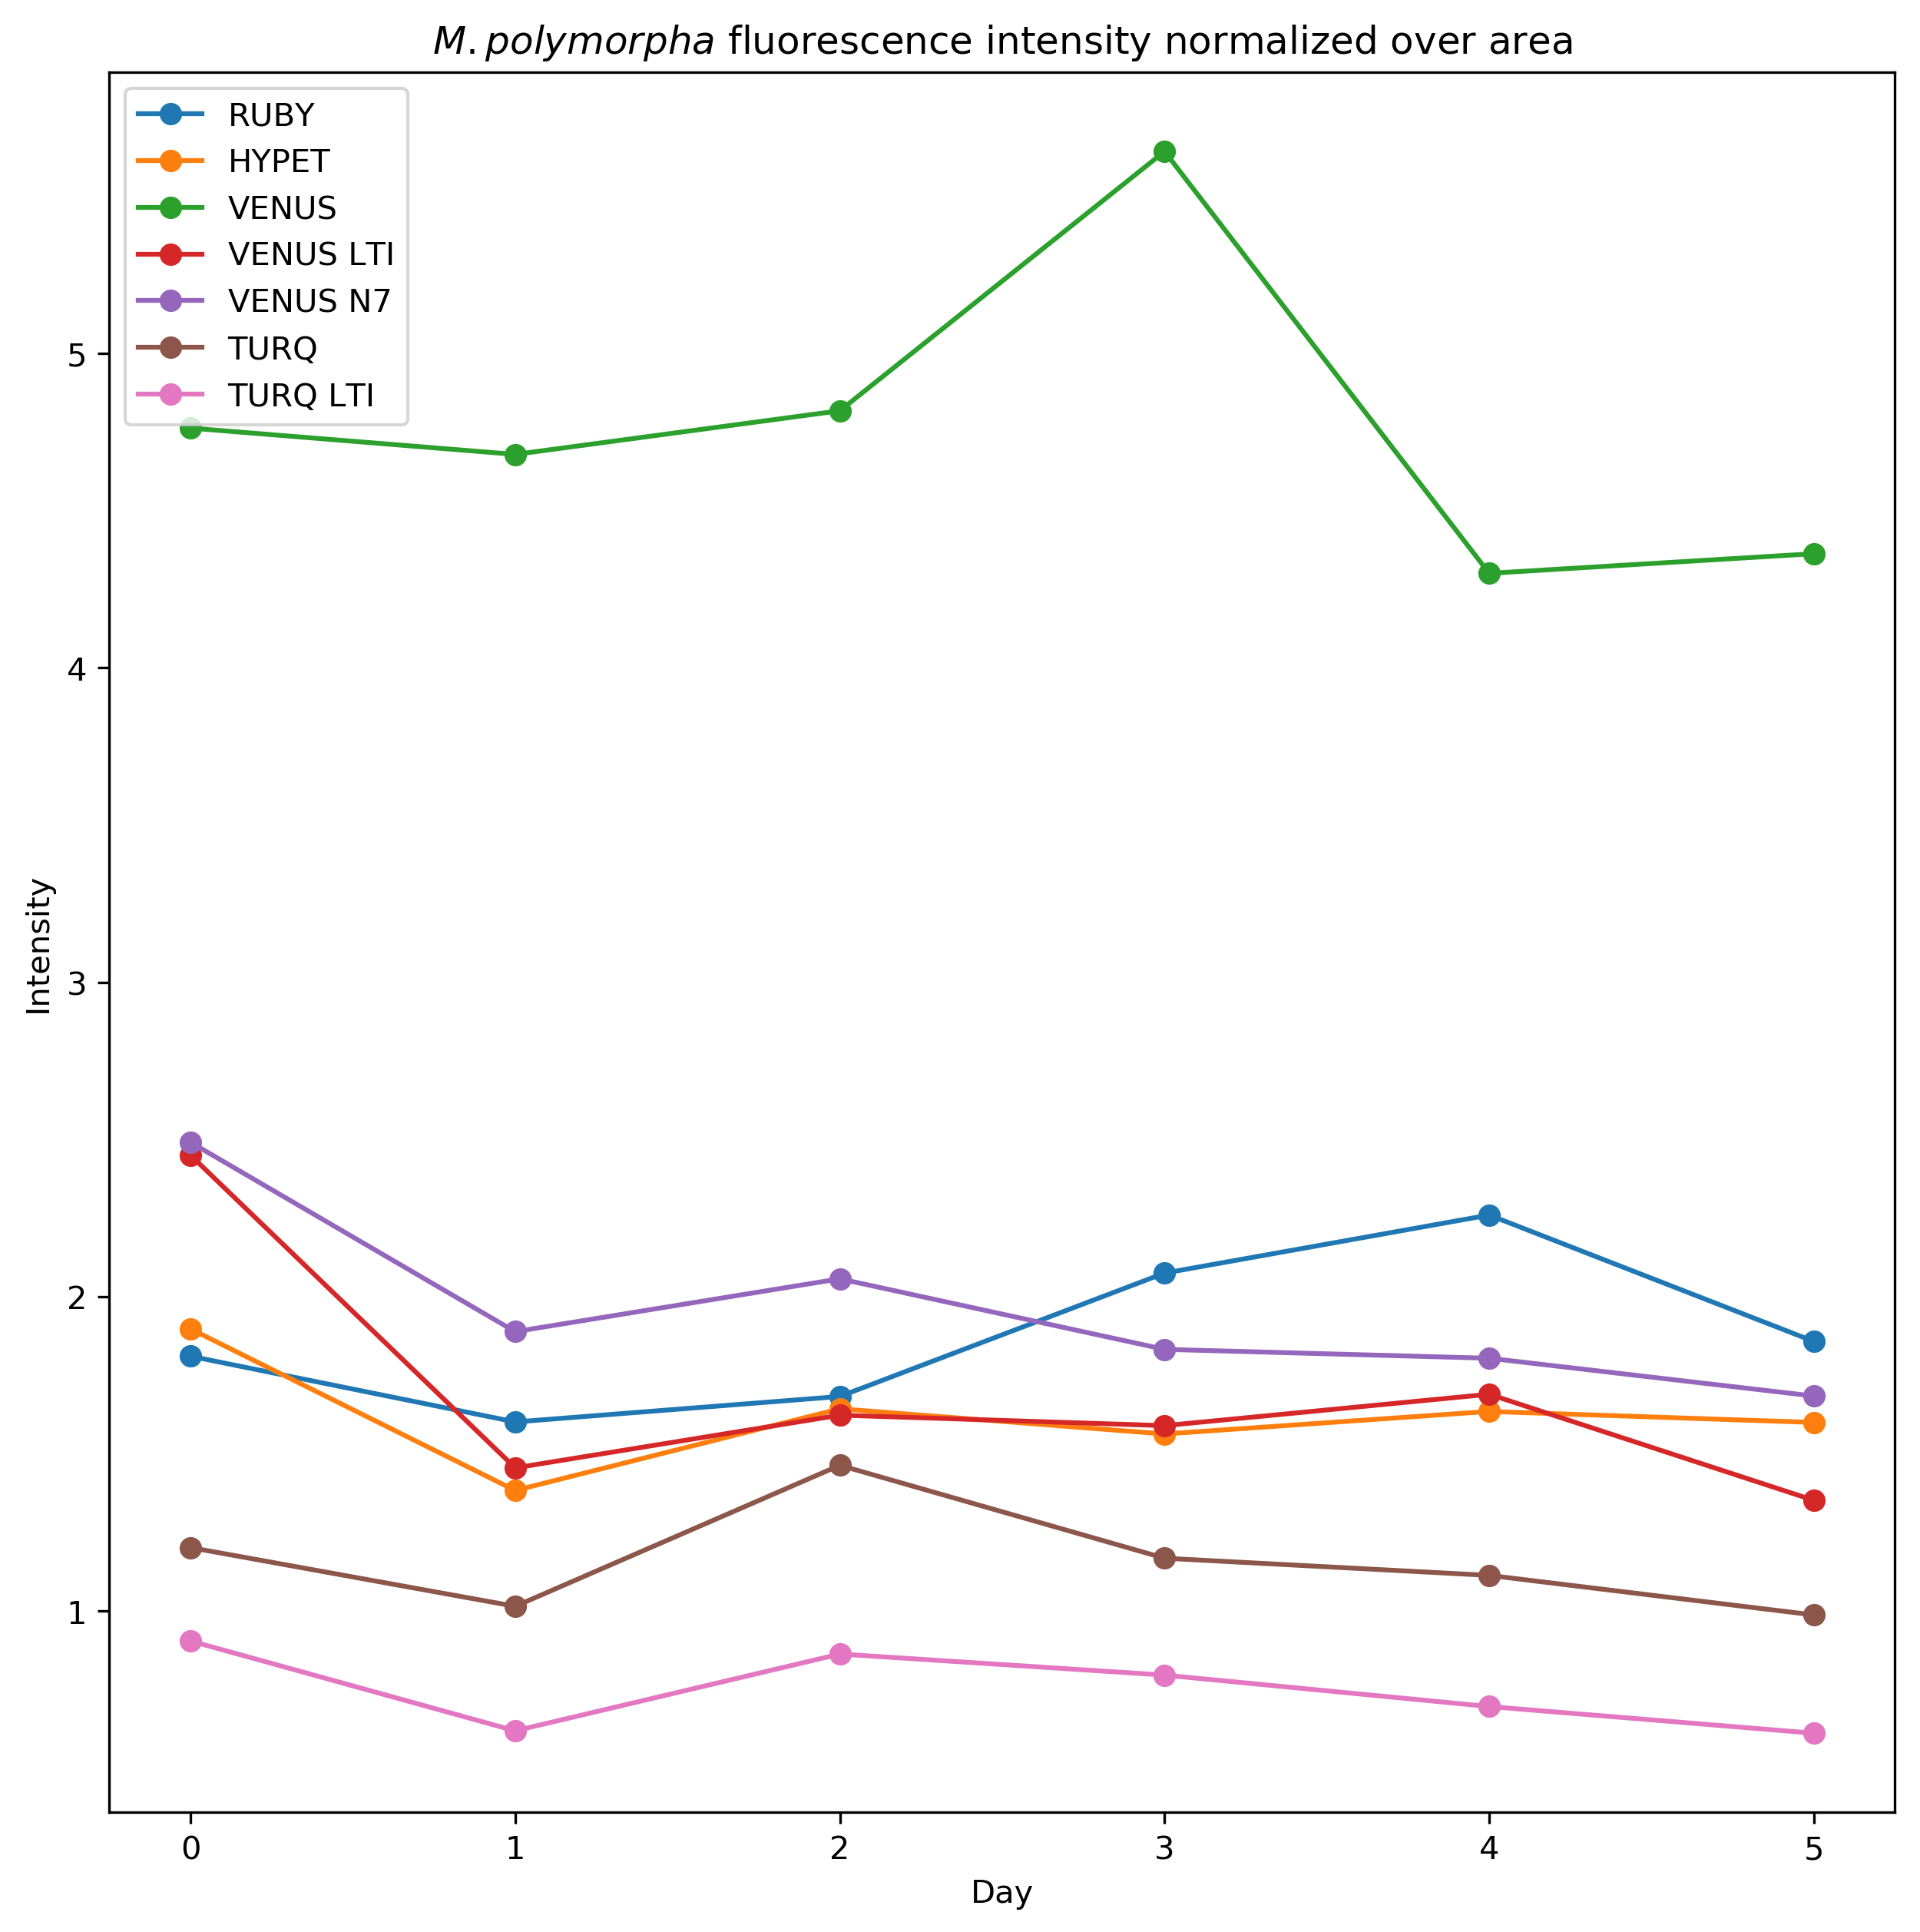

In [161]:
# Plotting the graphs

plt.figure(figsize = (10,10), dpi=300)
plt.title('$\it{M. polymorpha}$'+' fluorescence intensity normalized over area')
x_axis = [0,1,2,3,4,5]
for name in names_intensity:
    #plt.errorbar(x_axis, medias_grafico_area[name], yerr = desv_grafico_area[name], fmt='o', linestyle='-')
    plt.plot(x_axis, normalized[name], marker='o')
plt.legend(names_intensity, loc='upper left')
plt.ylabel('Intensity')
plt.xlabel('Day')

plt.savefig('/Users/alejandro/Desktop/MP Normalización I vs A.png', dpi=500)

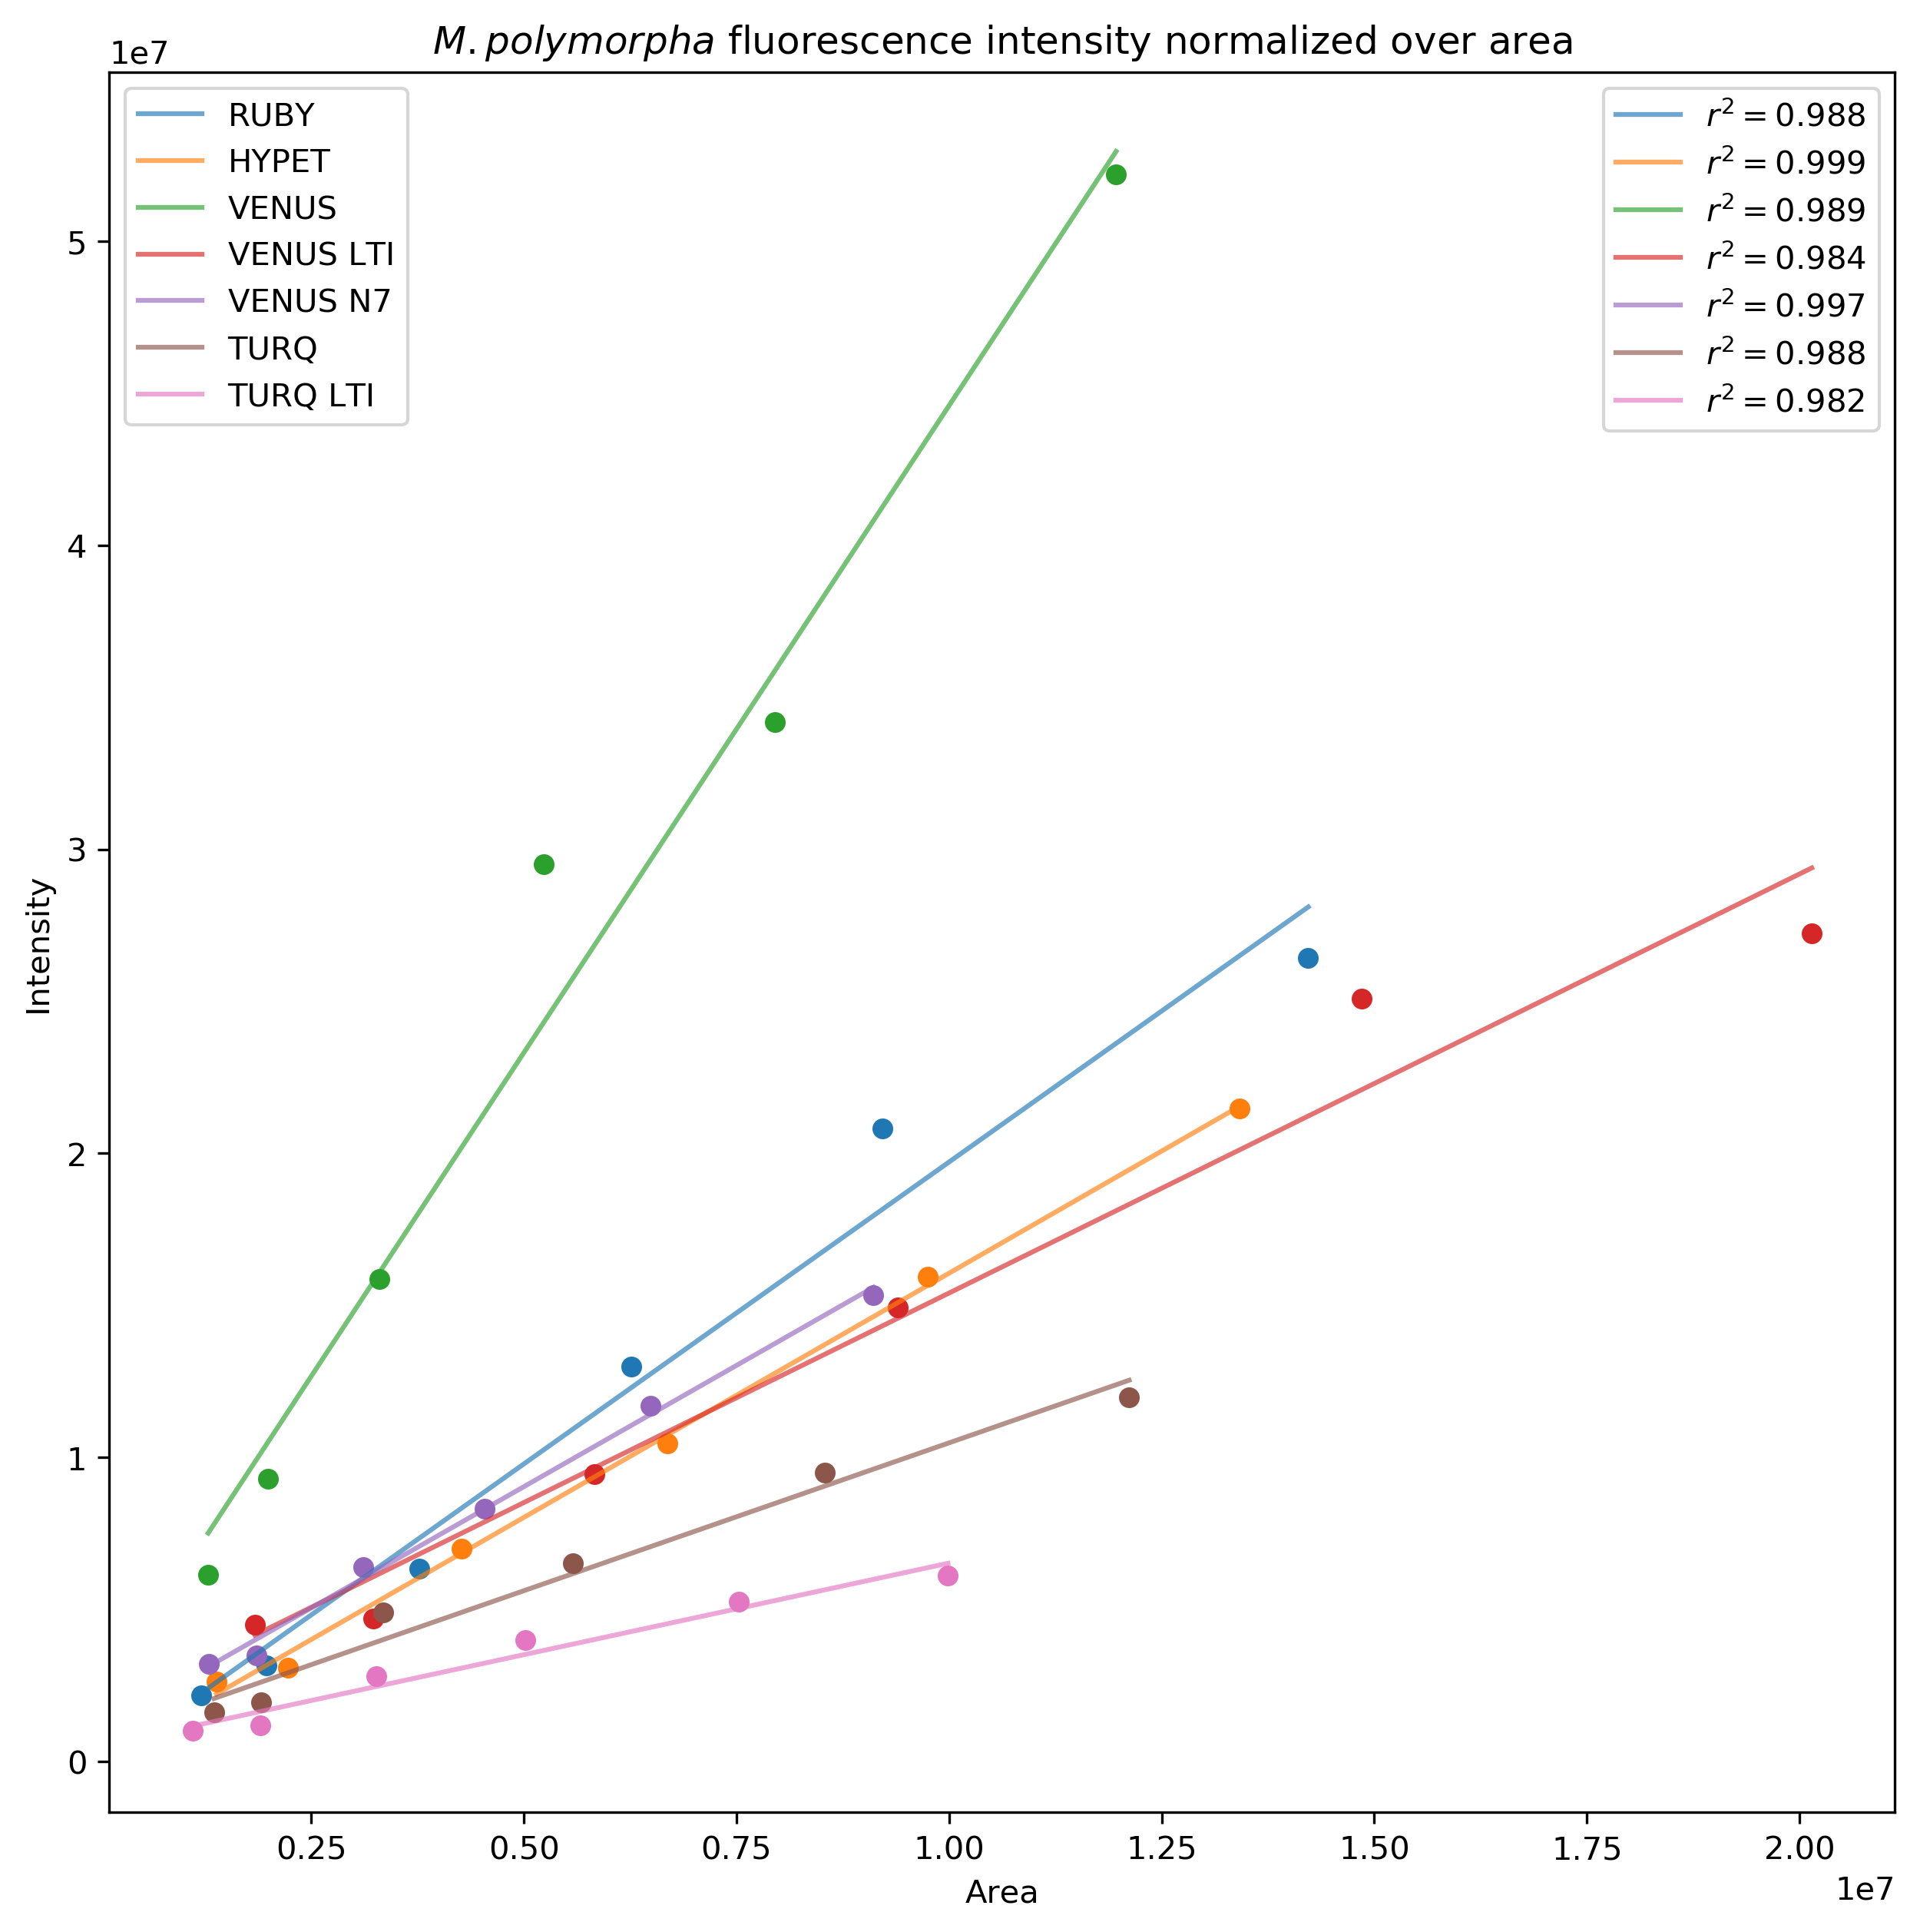

In [191]:
# Plotting the graphs

plt.figure(figsize = (10,10), dpi=300)
plt.title('$\it{M. polymorpha}$'+' fluorescence intensity normalized over area')
coeff = []

for name in names_intensity:
    #plt.errorbar(x_axis, medias_grafico_area[name], yerr = desv_grafico_area[name], fmt='o', linestyle='-')
    #plt.scatter(medias_grafico_area[name], medias_grafico_intensidad[name], s=50, marker='o')
    
    plt.plot(np.unique(medias_grafico_area[name]), np.poly1d(np.polyfit(medias_grafico_area[name], medias_grafico_intensidad[name], 1))(np.unique(medias_grafico_area[name])), alpha=0.65)
    plt.scatter(medias_grafico_area[name], medias_grafico_intensidad[name], s=30, marker='o')
    
    slope, intercept, r_value, p_value, std_err = stats.linregress(medias_grafico_area[name], medias_grafico_intensidad[name])
    r_val = round(r_value, 3)
    coeff.append('$r^2 = $'+str(r_val))
    
    
r_sq = plt.legend(coeff, loc='upper right')
plt.legend(names_intensity, loc='upper left')
plt.gca().add_artist(r_sq)
plt.ylabel('Intensity')
plt.xlabel('Area')

plt.savefig('/Users/alejandro/Desktop/MP Intensidad vs Area.png', dpi=500)